# 반도체 웨이퍼 결함 분류 모델 개발

![웨이퍼 사진](https://drive.google.com/uc?export=view&id=1BeMvyBkhknjzjS_cp3oPueDW8UlyJG8U)

A반도체 현장 담당자는 최근 웨이퍼 제조 공정의 결함 발생율이 이전과 비교해 높은 상황을 인지하고, 머신러닝 개발팀에 정확한 원인 파악 분석을 의뢰했다.

원인 파악을 위해서는,  웨이퍼 맵* 의 결함 패턴 인식 분석이 선행되어야 하며, 특히 혼합형 결함패턴 분석이 중요하다. <br>
(*테스트 프로브를 통해 웨이퍼 각 다이의 전기적 성능을 측정한 결과 데이터)

이제 당신은 머신러닝 개발팀의 담당자로서 웨이퍼 결함 데이터를 활용해 아래 주어진 문제를 해결하여야 한다.


In [ ]:
import os
import sys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!gdown https://drive.google.com/uc?id=1Wk7prJpbGOE4P3e-XhkZ7aTEdlvNSzu7
!unzip -qq '/content/project_dataset.zip' -d '/content/drive/MyDrive'

_dir = '/content/drive/MyDrive/project_dataset/'
sys.path.insert(0, _dir)
!pip install jdc

Mounted at /content/drive
Downloading...
From (original): https://drive.google.com/uc?id=1Wk7prJpbGOE4P3e-XhkZ7aTEdlvNSzu7
From (redirected): https://drive.google.com/uc?id=1Wk7prJpbGOE4P3e-XhkZ7aTEdlvNSzu7&confirm=t&uuid=a2dfbfda-1236-47cc-878a-b7795d9332cf
To: /content/project_dataset.zip
100% 1.14G/1.14G [00:18<00:00, 61.2MB/s]


## 라이브러리 불러오기

In [ ]:
import jdc
import sys
import json
import pickle
import random
import sklearn
import torchvision
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Sampler

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## [데이터 설명]

데이터셋은 25,263 (train: 21,498  test: 3765) 장의 웨이퍼 사진과 결함 패턴 class 쌍으로 구성되어있다.

해당 패턴을 분류해 보면,
- 1 종류의 정상 패턴 : C1 [0,0,0,0,0,0,0,0]
- 8 종류의 single 결함 패턴 : C2 [1,0,0,0,0,0,0,0] ~ C9 [0,0,0,0,0,0,0,1]
- 29 종류의 mixed 결함 패턴 <br>
이상 총 38개의 결함 패턴을 가지고 있다.

- `data[‘arr_0’]`, `data[‘arr_1’]` : shape (52, 52)의 ndarray 웨이퍼맵 이미지로, 픽셀의 값이 0은 blank spot, 1은 normal die, 그리고 2는 broken die를 의미한다.

- `data[‘arr_2’]`, `data[‘arr_3’]`: 결함의 종류를 나타내는 라벨로서, binary값을 가지고 있는 shape (8,) 의 ndarray 이다.

아래 그림은 38개의 결함 패턴을 시각화 한 자료이다.

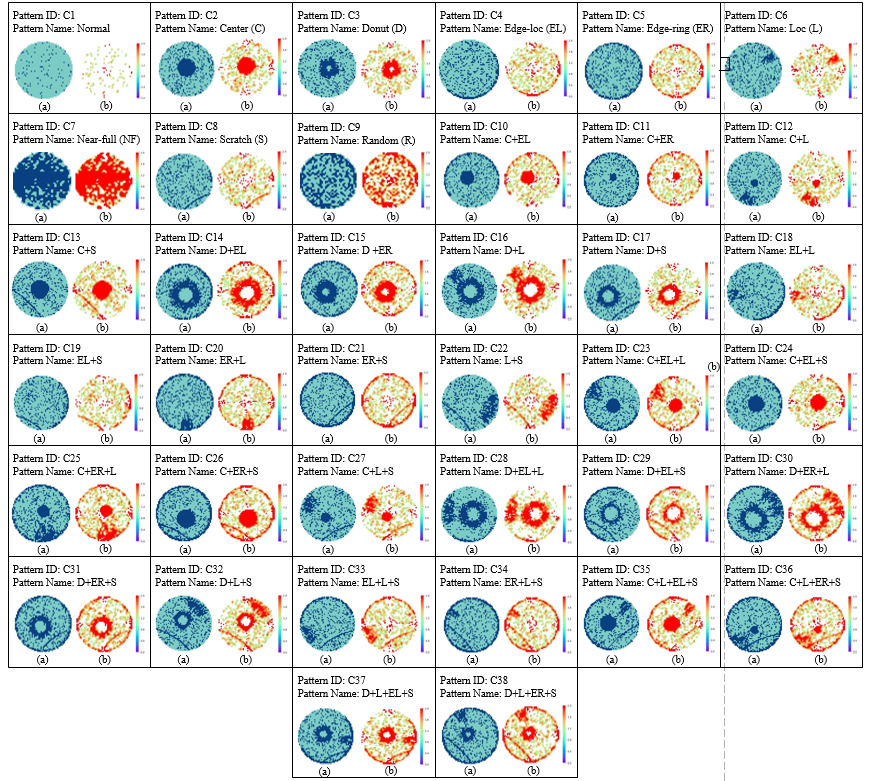

In [ ]:
# 데이터 로드
data_dir = os.path.join(_dir, "split.npz")
data = np.load(data_dir)
print(data.files)

X_train = data["arr_0"]
X_test = data["arr_1"]
y_train = data["arr_2"]
y_test = data["arr_3"]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

['arr_0', 'arr_1', 'arr_2', 'arr_3']
(21498, 52, 52) (3765, 52, 52) (21498, 8) (3765, 8)


[0 1 2]


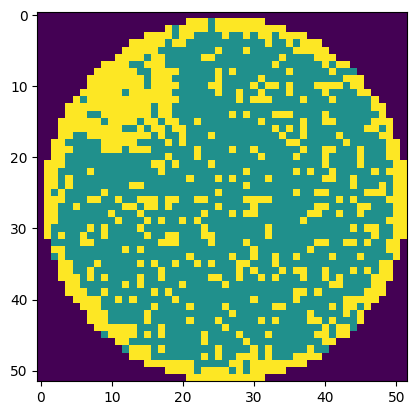

In [ ]:
print(np.unique(X_train[0]))
# 데이터 시각화
plt.imshow(X_train[0])

### [문제 1-1] 아래 내용에 따라 데이터 전처리를 수행하시오.
- `y_train`, `y_test`의 타입을 `ndarray`에서 `str`형태로 변환한다.
  - e.g., [1,0,0,0,0,0,0,0] -> "10000000")
  - 변환한 데이터를 `y_train_str`, `y_test_str` list에 저장한다.
- `value_counts_train`, `value_counts_test` 딕셔너리에 다음의 정보를 저장한다.
  - key : label ('string' 타입)
  - value : label의 전체 갯수 ('int' 타입)
  - value_counts_train : y_train_str 기반
  - value_counts_test : y_test_str 기반


In [ ]:
y_train_str = []
y_test_str = []

value_counts_train = {}
value_counts_test = {}

### Answer Start ###
for sub in y_train:
    sub_str = [str(l) for l in sub]
    y_train_str.append(''.join(sub_str))

for sub in y_test:
    sub_str = [str(l) for l in sub]
    y_test_str.append(''.join(sub_str))

value_counts_train = pd.DataFrame(y_train_str).value_counts()
value_counts_train = {k[0]: v for k, v in zip(value_counts_train.index, value_counts_train)}

value_counts_test = pd.DataFrame(y_test_str).value_counts()
value_counts_test = {k[0]: v for k, v in zip(value_counts_test.index, value_counts_test)}
### Answer End ###

### [답안 제출 1-1]


In [ ]:
print(value_counts_train)
print(value_counts_test)

{'00000010': 600, '01010000': 600, '01011010': 600, '00101000': 600, '00100000': 600, '00011010': 600, '01010010': 600, '10010000': 600, '10101010': 600, '10100010': 600, '10000010': 600, '01001000': 600, '01000010': 600, '01000000': 600, '01101010': 600, '10001000': 600, '01100010': 600, '00011000': 598, '00001010': 598, '00101010': 596, '01001010': 595, '10001010': 595, '01011000': 594, '00010010': 593, '00010000': 593, '10100000': 592, '00100010': 591, '01101000': 590, '00000000': 589, '10011010': 588, '10011000': 585, '10010010': 584, '01100000': 580, '10000000': 563, '00001000': 561, '00000001': 529, '10101000': 100, '00000100': 84}
{'00000000': 100, '00000001': 100, '00000010': 100, '00001000': 100, '00001010': 100, '00010000': 100, '01100000': 100, '00010010': 100, '00011000': 100, '00011010': 100, '00100000': 100, '00100010': 100, '00101000': 100, '00101010': 100, '01000000': 100, '01000010': 100, '01001000': 100, '01001010': 100, '01010000': 100, '01010010': 100, '01011000': 1

### [상황 설명 1-1]
변환된 라벨을 기반으로 데이터를 시각화 해보자.

In [ ]:
target_labels = ['10100010', '00000000', '10001000', '01100000', '01100010']
vis_imgs = []

idxs = []
for tl in target_labels:
    cnt = 0
    for idx, l in enumerate(y_train_str):
        if tl == l:
            cnt += 1
            idxs.append(idx)
            if cnt >= 6:
                break

for idx in idxs:
    vis_imgs.append(X_train[idx])

vis_imgs = np.stack(vis_imgs)

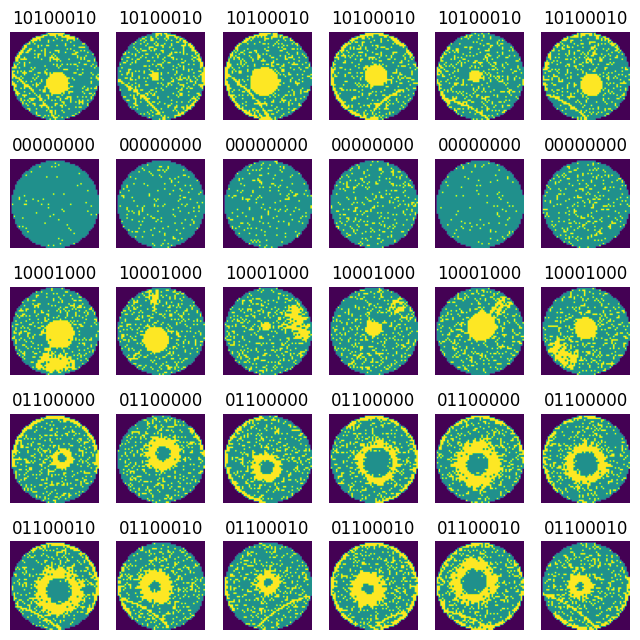

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=6, figsize=(8, 8))

#### iterate over the grid and plot each image #####
for i in range(5):
    for j in range(6):
        axs[i, j].imshow(vis_imgs[i*6+j])
        axs[i, j].axis('off')
        axs[i, j].set_title(target_labels[i])


In [ ]:
class My_Dataset(Dataset):

    def __init__(self, X, y, transform = None):

        self.images = X.reshape(-1,1, 52, 52) # CNN 연산 또는 transform을 위해 3채널로 바꿔줌.
        print("X", X.shape)
        print("self.images", self.images.shape)
        self.binary_labels = y
        self.transform = transform

        self.classes_dict = {
            "00000000":0,
            "10000000":1,
            "01000000":2,
            "00100000":3,
            "00010000":4,
            "00001000":5,
            "00000100":6,
            "00000010":7,
            "00000001":8,
            "10100000":9,
            "10010000":10,
            "10001000":11,
            "10000010":12,
            "01100000":13,
            "01010000":14,
            "01001000":15,
            "01000010":16,
            "00101000":17,
            "00100010":18,
            "00011000":19,
            "00010010":20,
            "00001010":21,
            "10101000":22,
            "10100010":23,
            "10011000":24,
            "10010010":25,
            "10001010":26,
            "01101000":27,
            "01100010":28,
            "01011000":29,
            "01010010":30,
            "01001010":31,
            "00101010":32,
            "00011010":33,
            "10101010":34,
            "10011010":35,
            "01101010":36,
            "01011010":37,
        }

        self.classes_num_dict = {}
        self.image_labels = []
        self.images_num = []


        for binary_label in self.binary_labels:

            t = ""
            for ch in binary_label:
                if ch == None:
                    t += str(0)
                else:
                    t += str(ch)
            label = self.classes_dict[t]

            if label not in self.classes_num_dict:
                self.classes_num_dict[label] = 1
            else:
                self.classes_num_dict[label] += 1
            self.image_labels.append(label)

        for i in sorted(list(self.classes_num_dict.keys())):
            self.images_num.append(self.classes_num_dict[i])

        self.num_classes = len(self.classes_num_dict)


        print("num_class：", self.num_classes)
        print("{} images were  found in the dataset.".format(sum(self.images_num)))


    def __len__(self):
        return sum(self.images_num)

    def __getitem__(self, idx):

        ### Answer Start ###
        image = self.images[idx]
        label = self.image_labels[idx]

        print("image", image.shape)
        print("label", label)
        # image = ...
        # label = ...
        ### Answer End ###

        if self.transform is not None:
            image = Image.fromarray(image[0])
            image = self.transform(image)
        return image, label

### [상황설명 1-2]

분류 문제를 풀기 위해 딥러닝 모델을 구현하고자 한다.

이를 위해 Dataset과 Dataloader instance를 생성한다.

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

"""
dataset
"""
train_dataset = My_Dataset(X_train, y_train)
test_dataset = My_Dataset(X_test, y_test)
val_num = len(test_dataset)

print(type(train_dataset[0][0]))
print(train_dataset[0][0].dtype)
print(X_train.shape)
print(X_test.shape)


"""
dataloader
"""

batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=2, drop_last=False)
print(len(train_loader))
print(len(test_loader))

X (21498, 52, 52)
self.images (21498, 1, 52, 52)
num_class： 38
21498 images were  found in the dataset.
X (3765, 52, 52)
self.images (3765, 1, 52, 52)
num_class： 38
3765 images were  found in the dataset.
image (1, 52, 52)
label 19
<class 'numpy.ndarray'>
image (1, 52, 52)
label 19
int32
(21498, 52, 52)
(3765, 52, 52)
335
942


아래 그림은 구현하려는 모델 `Net`의 `self.features` 와, activation output을 시각화 한 그림이다.

(빨간색 숫자는 activation output의 크기를 나타낸다.)

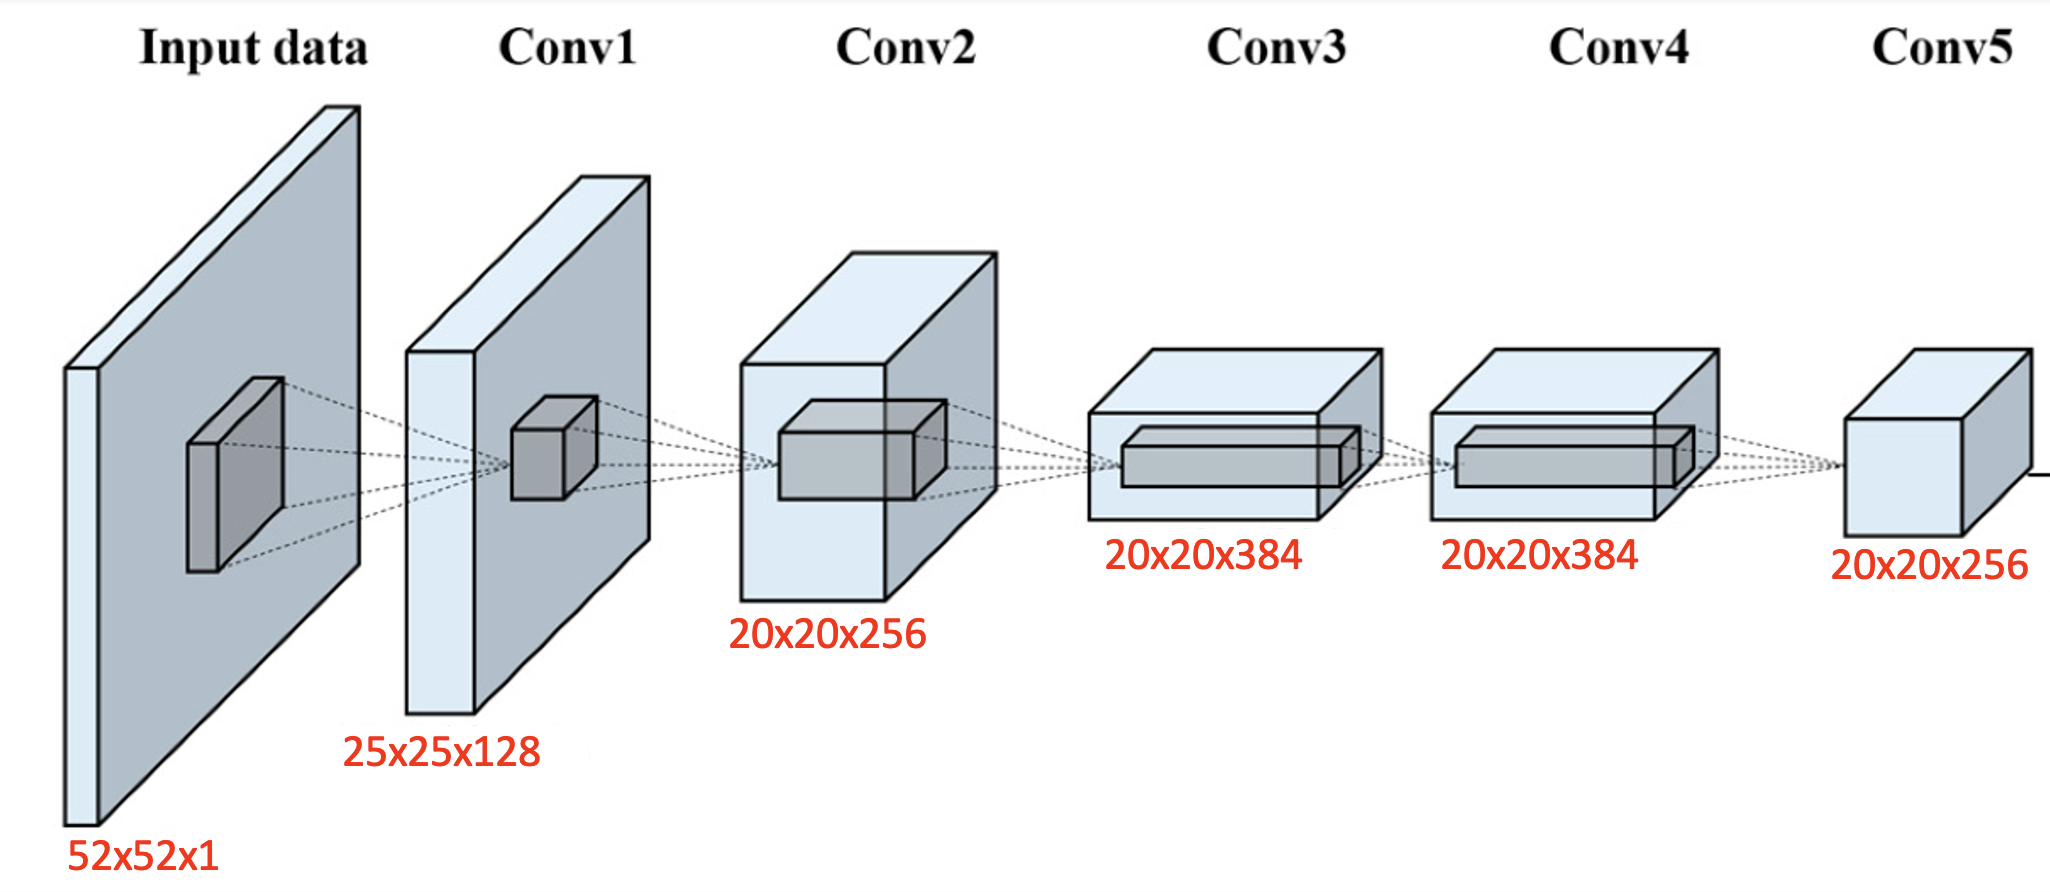

### [문제 2]  init 함수 내 `self.features` 코드를 완성하시오.


In [ ]:
class Net(nn.Module):
    def __init__(self, num_classes=1000):
        super(Net, self).__init__()
        self.features = nn.Sequential(

            # 2-1
            # Conv1
            ### Answer Start ###
            nn.Conv2d(1, 128, kernel_size=3, stride=1, padding=1),  # input[1, 52, 52]  output[128, 52, 52]
            ### Answer End ###
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[128, 25, 25]

            # Conv2
            ### Answer Start ###
            nn.Conv2d(128, 256, kernel_size=5, padding=10),         # output[256, 41, 41]
            ### Answer End ###
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[256, 20, 20]

            # Conv3
            ### Answer Start ###
            nn.Conv2d(256, 384, kernel_size=3, padding=1),          # output[384, 20, 20]
            ### Answer End ###
            nn.ReLU(inplace=True),

            # Conv4
            ### Answer Start ###
            nn.Conv2d(384, 384, kernel_size=3, padding=1),          # output[384, 20, 20]
            ### Answer End ###
            nn.ReLU(inplace=True),

            # Conv5
            ### Answer Start ###
            nn.Conv2d(384, 256, kernel_size=3, padding=1),          # output[256, 20, 20]
            ### Answer End ###
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),                  # output[256, 9, 9]

        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 9 * 9, 4096), # output[65536, 4096]
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

def get_model(num_classes):
    model = Net(num_classes=num_classes)
    return model

### [답안 제출 2]

In [ ]:
net = get_model(num_classes=38)
x = torch.rand(5,1,52,52)
out = net(x)

print(out.shape)
print(out.tolist())

torch.Size([5, 38])
[[0.000986857688985765, -0.010496500879526138, -0.018294934183359146, -0.006661948747932911, 0.004068112000823021, -0.004023635759949684, 0.008386483415961266, 0.010413160547614098, -0.0033225324004888535, 0.004823010414838791, 0.014230634085834026, 0.00939436350017786, -0.0075956108048558235, -0.01291520707309246, -0.004403437487781048, -0.014954919926822186, 0.00230367761105299, -0.006279601249843836, 0.008590156212449074, 0.013567144982516766, 0.009843351319432259, 0.005509599577635527, 0.011603373102843761, -0.015653472393751144, -0.004254991188645363, 0.001631464809179306, -0.0015120755415409803, 0.006283519323915243, -0.016004670411348343, 0.009093161672353745, 0.006933494936674833, 0.009481295943260193, 0.014294339343905449, -0.009687850251793861, 5.648867227137089e-05, -0.01612861268222332, 0.014571832492947578, -0.016576599329710007], [0.0009730509482324123, -0.010524052195250988, -0.01855108141899109, -0.006663278676569462, 0.004156815819442272, -0.0039472

### [문제 3-1] 모델 학습 코드를 완성하시오.

- 맞춘 정답 개수 `acc_num`을 계산하시오.
<br><br>

### [문제 3-2] 모델 평가 코드를 완성하시오.

- 정답 개수 `acc_num`을 계산하시오.



In [ ]:
def train(net, loss_function, optimizer, img_size=52, training=True):
    best_acc = 0.0
    resize = transforms.Resize(img_size)

    for epoch in range(epochs):
        # train
        if training:
            net.train()
            acc_num = torch.zeros(1).to(device)
            sample_num = 0
            train_bar = tqdm(train_loader, file=sys.stdout, ncols=100)
            for step, data in enumerate(train_bar):
                images, labels = data
                images, labels = images.float().to(device), labels.to(device)
                sample_num += images.shape[0] # 【batch, chennel, height, width】
                if img_size != 52:
                    images = resize(images)

                # 3-1
                ### Answer Start ###
                optimizer.zero_grad()
                outputs = net(images)
                loss = loss_function(outputs, labels.to(device))
                loss.backward()
                optimizer.step()

                pred_class = torch.max(outputs, dim=1)[1]
                acc_num += torch.eq(pred_class, labels).sum()
                # Model training code
                # acc_num = ...

                ### Answer End ###


            train_acc = acc_num.item() / sample_num
            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch+1, epochs, loss)

        # validate
        net.eval()
        acc_num = 0.0
        with torch.no_grad():
            for val_data in test_loader:
                val_images, val_labels = val_data
                val_images, val_labels = val_images.float().to(device), val_labels.to(device)
                if img_size != 52:
                    val_images = resize(val_images)

                # 3-2
                ### Answer Start ###
                outputs = net(val_images)
                predict_y = torch.max(outputs, dim=1)[1]
                acc_num += torch.eq(predict_y, val_labels).sum().item()
                # acc_num = ...

                ### Answer End ###

        val_accurate = acc_num / val_num
        if training:
            print('[epoch %d] train_loss: %.3f train_acc: %.3f val_accuracy: %.3f' % (epoch+1, loss, train_acc, val_accurate))
        else:
            print('[epoch %d] val_accuracy: %.3f' % (epoch+1, val_accurate))


        if val_accurate > best_acc:
            best_acc = val_accurate

        print(f'best accuracy: {best_acc}')

    return best_acc


### [답안 검증 3]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = get_model(num_classes=38)
net.to(device)

loss_function = CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=3e-5)
epochs = 5

best_acc = train(net, loss_function, optimizer)
print("Finished Training")

Streaming output truncated to the last 5000 lines.
image25label 
6 
(1, 52, 52)label
 image10 
(1, 52, 52)image (1, 52, 52)

label 36label

 image1 
(1, 52, 52)image
 label(1, 52, 52)label 33 
25
image (1, 52, 52)
label 7
image (1, 52, 52)
labelimage  35(1, 52, 52)
label 25
image
image  (1, 52, 52)
label 29
(1, 52, 52)image 
(1, 52, 52)label
label 9
image (1, 52, 52)
label  2728

image (1, 52, 52)
label 20
imageimage  (1, 52, 52)(1, 52, 52)

label 34
image (1, 52, 52)
label 9
imagelabel (1, 52, 52) 
label1 
image (1, 52, 52)
12label 2
image (1, 52, 52)

image label (1, 52, 52)1
image
label (1, 52, 52) 4

labelimage  12
(1, 52, 52)
labelimage  3(1, 52, 52)

image label(1, 52, 52) 5
label
 image 28
(1, 52, 52)
image label (1, 52, 52)
27
labelimage  31
(1, 52, 52)
imagelabel  (1, 52, 52)25

labelimage  33(1, 52, 52)

image (1, 52, 52)label
 label19
 image7 
(1, 52, 52)
imagelabel  17
(1, 52, 52)image (1, 52, 52)

labellabel  257

imageimage  (1, 52, 52)
(1, 52, 52)label
 label36
 image9 (

KeyboardInterrupt: 

### [상황 설명 4]
베이스라인 모델 `Net`의 학습과 평가를 완료하였다. <br>
이제 모델의 성능을 향상시키기 위해, Vision Transformer 모델을 도입해 보기로 했다.

현재 모델 코드 중 transformer encoder 코드는 준비되어 있다. <br>
다만 모델에서 우리가 가진 이미지 데이터를 입력받기 위해서는, 전처리 구현이 필요한 상황이다.

<br>
ViT 전처리의 과정은 다음과 같다:

- 이미지를 patch 단위로 자른다.
    - pixel 단위로 이미지를 처리할 경우 sequence length가 너무 커지기 때문에 patch 단위의 처리가 필요하다.

- 각각의 patch를 linear projection을 통해 token embedding으로 만든다.

- sequence의 가장 앞에 class embedding을 추가한다.

- 각각의 token embedding에 positional embedding을 더한다.
    - token 별로 서로 다른 *학습 가능한* positional embedding을 더해줌으로서 각 patch의 위치 정보를 넣어준다.



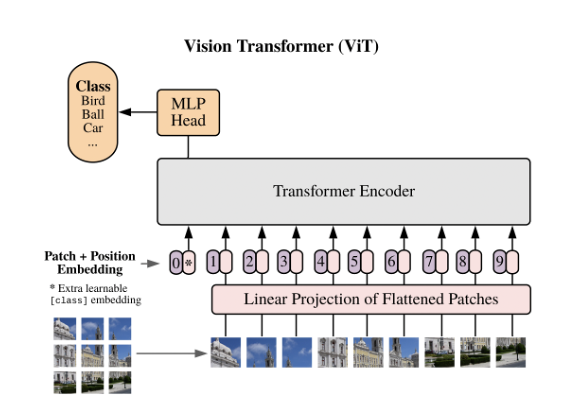

출처: AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE (ICLR'21)

### [문제 4] ViT 전처리 코드를 구현하시오.

- `conv_proj`: 이미지를 patch 단위로 나눈 후 linear projection 시키는 neural net layer(s). (힌트: convolution layer로 한번에 구현 가능)

- `class_token`: (1, 1, `hidden_dim`) 사이즈의 모든 값이 0으로 초기화된 학습 가능한 텐서. (힌트: nn.Parameter 사용)

- `seq_length`: Patch의 개수 (힌트: `class_token`도 포함)

- `pos_embedding`: (1, `seq_length`, `hidden_dim`) 사이즈의 값이 std=0.02의 normal distribution으로 초기화된 학습 가능한 텐서. (힌트: nn.Parameter 사용)

- `process_input`: `image_size`(=224) 크기의 이미지를 입력으로 받아 sequence of token embedding을 반환하는 전처리 함수. 주석의 텐서 shape을 참고하여 코드를 작성할 것.
	- `class_token`은 sequence의 가장 앞부분에 concat 된다.

In [ ]:
patch_size = 16
hidden_dim = 768
image_size = 224

### Answer Start ###
conv_proj = nn.Conv2d(
    in_channels=1, out_channels=hidden_dim, kernel_size=patch_size, stride=patch_size
)
class_token = nn.Parameter(torch.zeros(1, 1, hidden_dim))

seq_length = (image_size // patch_size) ** 2 + 1

pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_dim).normal_())
# conv_proj = ...
# class_token = ...
# pos_embedding = ...

### Answer End ###


def process_input(x: torch.Tensor) -> torch.Tensor:
    n, c, h, w = x.shape
    p = patch_size

    n_h = h // p
    n_w = w // p


	  # patchify and linear projection
    # (n, c, h, w) -> (n, hidden_dim, n_h, n_w)
    ### Answer Start ###
    x = conv_proj(x)
    ### Answer End ###

    # (n, hidden_dim, n_h, n_w) -> (n, hidden_dim, (n_h * n_w))
    ### Answer Start ###
    x = x.reshape(n, hidden_dim, n_h * n_w)
    ### Answer End ###


    # (n, hidden_dim, (n_h * n_w)) -> (n, (n_h * n_w), hidden_dim)
    ### Answer Start ###
    x = x.permute(0, 2, 1)
    ### Answer End ###

    n = x.shape[0]

    # Expand the class token to the full batch and concatenate in front of the sequence
    # add positional embedding
    ### Answer Start ###
    batch_class_token = class_token.expand(n, -1, -1)
    x = torch.cat([batch_class_token, x], dim=1)
    x = x + pos_embedding
    ### Answer End ###

    return x

### [답안 검증 4]
ViT 학습 시간이 길기 때문에, 미리 학습된 ViT 모델을 로드하여 validation 성능을 확인해 본다.

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

with open(os.path.join(_dir, 'q4.pkl'), 'rb') as fd:
    net = pickle.load(fd)

print(net)

In [ ]:
epochs=1
train(net, None, None, img_size=224, training=False)

### [답안 제출 4]

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

x = torch.randn(1,1,224,224)
out = process_input(x)

print(out.tolist())

### [상황 설명 5-1]


분류 과제의 구현이 완료되었으므로, 이제 class imbalance 문제가 있는지 파악해 볼 필요가 있다.

우선 class별 정확한 성능을 파악해보기 위해, confusion matrix를 통해 시각화 하기로 하였다.

다시 CNN 모델을 캐시에서 불러온다.

In [ ]:
with open(os.path.join(_dir, 'q5.pkl'), 'rb') as fd:
    net = pickle.load(fd)

In [ ]:
print(net)

Net(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(10, 10))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=20736, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, i

### [문제 5-1] Confusion Matrix 계산 코드를 구현하시오.

- Test 데이터에 대한 예측값 `y_preds` (Python `float` 타입)을 구현한다
- 실제 정답 라벨 `y_trues` (Python `float` 타입)을 구현한다.



In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

def get_confusion_matrix(net, test_loader):
    y_preds = []
    y_trues = []

    with torch.no_grad():
        for val_data in test_loader:
            ### Answer Start ###
            val_images, val_labels = val_data
            val_images = val_images.float()
            outputs = net(val_images.to(device))
            predict_y = torch.max(outputs, dim=1)[1]

            y_preds.extend(predict_y.cpu().numpy().tolist())
            y_trues.extend(val_labels.numpy().tolist())
            # y_trues = ...
            # y_preds = ...

            ### Answer End ###


    cf_matrix = confusion_matrix(y_trues, y_preds)
    return cf_matrix, y_preds, y_trues


### [답안 검증 5-1]
위에서 구현한 코드를 통해 Confusion matrix를 볼 수 있다.

- 세로축 (y축): 실제 클래스 (True labels)
- 가로축 (x축): 예측된 클래스 (Predicted labels)
- 대각선 요소: 모델이 정확하게 예측한 비율을 나타냅니다 (True Positives).
- 비대각선 요소: 모델이 잘못 예측한 비율을 나타냅니다 (False Positives 또는 False Negatives).





<Axes: >

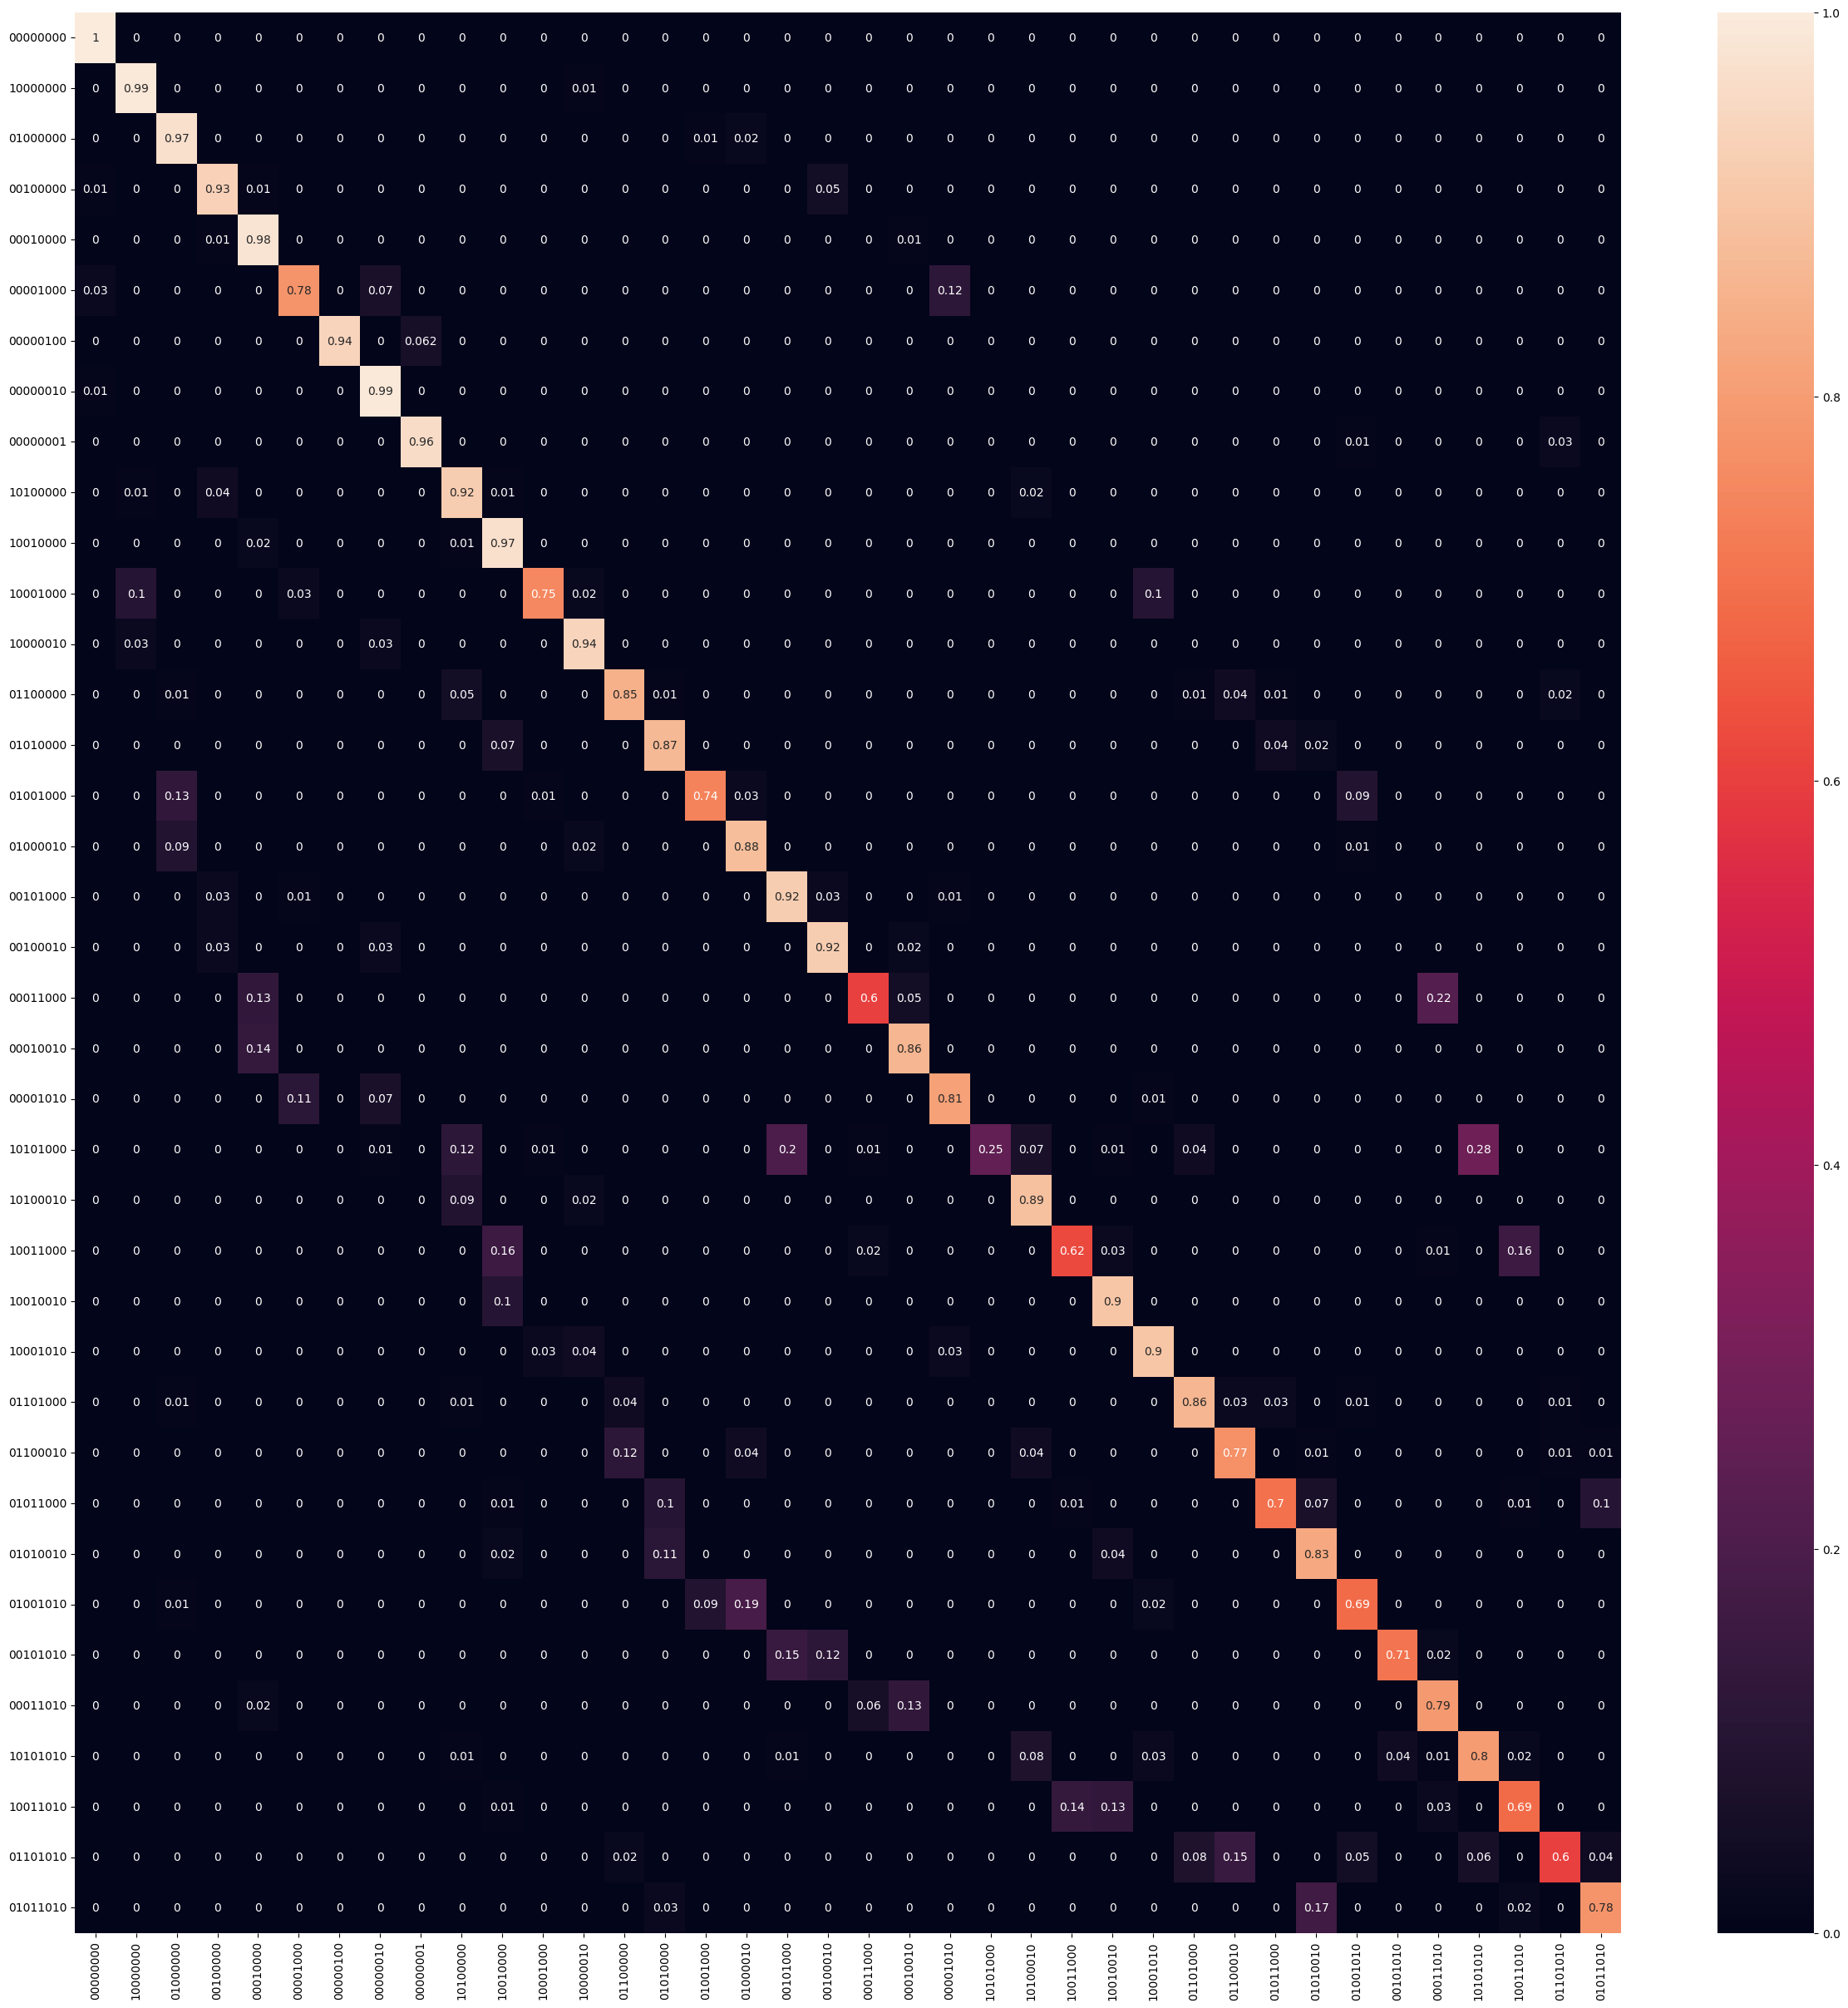

In [ ]:
cf_matrix, y_preds, y_trues = get_confusion_matrix(net, test_loader)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in train_dataset.classes_dict], columns = [i for i in train_dataset.classes_dict])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

### [상황 설명 5-2]

Confusion Matrix를 통해 class imbalance 현상을 확인하였다.

특히 `10101000`같은 소수 class의 중요도는 높지만, 절대적인 수가 작기 때문에 metric에 적게 반영된다는 문제가 있다.

따라서 accuracy가 아니라 class별 F1 score를 계산하고, 모든 class를 합친 macro F1 score를 계산하고자 한다.

### [문제 5-2] Multiclass Macro F1 score 계산 코드를 구현하시오.

- 반환값은 다음과 같다.
- `f1` : List[Flaot] type의 class별 F1 score
- `macro_f1` : float type의 macro F1 score


In [ ]:
def multiclass_f1(y_trues, y_preds):
    ### Answer Start ###
    macro_f1 = sklearn.metrics.f1_score(y_trues, y_preds, average='macro')
    f1 = sklearn.metrics.f1_score(y_trues, y_preds, average=None)
    # macro_f1 = ...
    # f1 = ...

    ### Answer End ###

    return f1, macro_f1

f1, macro_f1 = multiclass_f1(y_trues, y_preds)
print(f1)
print(macro_f1)

[0.97560976 0.92957746 0.87387387 0.91176471 0.85217391 0.80829016
 0.96825397 0.9        0.96       0.83257919 0.82553191 0.83333333
 0.91707317 0.83743842 0.82075472 0.80434783 0.81481481 0.80701754
 0.86792453 0.71005917 0.83091787 0.82233503 0.4        0.84761905
 0.70056497 0.85308057 0.87378641 0.86432161 0.77386935 0.78651685
 0.79047619 0.74193548 0.81142857 0.75961538 0.74766355 0.72631579
 0.71856287 0.80829016]
0.8186241624328026


### [상황 설명 5-3]
Class imbalance 문제를 파악했고, 이 상황에서 적합한 평가 지표인 macro F1 score를 구현했다.

이제 class imbalance 문제를 해결해서 소수 class에 대한 모델의 성능을 높이고자 한다.

일반적으로 많이 사용하는 Over sampling* method를 구현해보자.

* Over sampling : 학습 과정에서 데이터 수가 적은 class를 더 많이 sampling 해 소수 class에 대한 성능을 높이는 기법


### [문제 5-3] Over sampling을 구현한 `WeightedSampler` 코드를 완성하시오.

- `Sampler` : `DataLoader` instance에 인자로 사용되어 데이터 샘플링 방식을 결정한다.

- `self.weights`: `torch.tensor` type 의 데이터 샘플 별 가중치 값으로, 각 샘플의 가중치 값은 해당 샘플이 속한 class의 데이터 수의 역수에 해당한다.


In [32]:
class WeightedSampler(Sampler):

    def __init__(self, dataset, balanced, num_samples):
        self.balanced = balanced
        self.num_samples = num_samples
        self.dataset = dataset

        self.indices = pd.DataFrame(dataset.image_labels).index

        if balanced == True:

            ### Answer Start ###
            weights_map = (1/pd.DataFrame(dataset.image_labels).value_counts(sort=False))
            weights_map = weights_map.to_dict()
            weights_map = {k[0]: v for k, v in weights_map.items()}
            weights = [weights_map[i] for i in dataset.image_labels]
            self.weights = torch.tensor(weights, dtype=torch.double)
            # self.weights = ...

            ### Answer End ###


    def __iter__(self):
        if self.balanced == True:
            return (i for i in torch.multinomial(self.weights, self.num_samples, replacement=True))
        else:
            return (i for i in torch.randint(high=len(self.indices), size=self.num_samples))

    def __len__(self):
        return self.num_samples

### [답안 검증 5-3]

In [ ]:
weighted_sampler = WeightedSampler(train_dataset, True, len(train_dataset))
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=2, drop_last=True, sampler=weighted_sampler)

all_list = []
for data in train_loader:
    all_list += data[1].tolist()

print(pd.DataFrame(all_list).value_counts())

35    616
33    604
0     592
15    586
6     585
23    582
13    582
32    581
27    580
10    579
26    578
28    577
14    577
36    576
22    574
19    572
11    570
16    568
29    568
34    568
5     568
25    567
2     564
4     564
31    563
24    562
3     552
20    552
8     551
1     549
30    545
9     539
37    537
12    531
17    530
7     526
18    516
21    509
Name: count, dtype: int64


### [상황 설명]

Over sampling을 통해 모델을 다시 학습시키고, 이전 모델과 (문제 3번) 성능을 비교해보자.



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = get_model(num_classes=38)
net.to(device)

loss_function = CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=3e-5)
epochs = 5

train(net, loss_function, optimizer)

100%|█████████████████████████████████████████████████████████████| 335/335 [00:53<00:00,  6.30it/s]
[epoch 1] train_loss: 2.192 train_acc: 0.109 val_accuracy: 0.333
best accuracy: 0.33280212483399735
100%|█████████████████████████████████████████████████████████████| 335/335 [00:52<00:00,  6.40it/s]
[epoch 2] train_loss: 1.661 train_acc: 0.382 val_accuracy: 0.450
best accuracy: 0.449933598937583
100%|█████████████████████████████████████████████████████████████| 335/335 [00:52<00:00,  6.37it/s]
[epoch 3] train_loss: 0.749 train_acc: 0.569 val_accuracy: 0.768
best accuracy: 0.7681274900398406
100%|█████████████████████████████████████████████████████████████| 335/335 [00:52<00:00,  6.39it/s]
[epoch 4] train_loss: 0.841 train_acc: 0.742 val_accuracy: 0.826
best accuracy: 0.8257636122177955
100%|█████████████████████████████████████████████████████████████| 335/335 [00:52<00:00,  6.40it/s]
[epoch 5] train_loss: 0.381 train_acc: 0.826 val_accuracy: 0.868
best accuracy: 0.8677290836653386


0.8677290836653386

### [상황 설명]
학습된 모델의 confusion matrix와 f1 score를, 이전 모델과 비교해보자.



<Axes: >

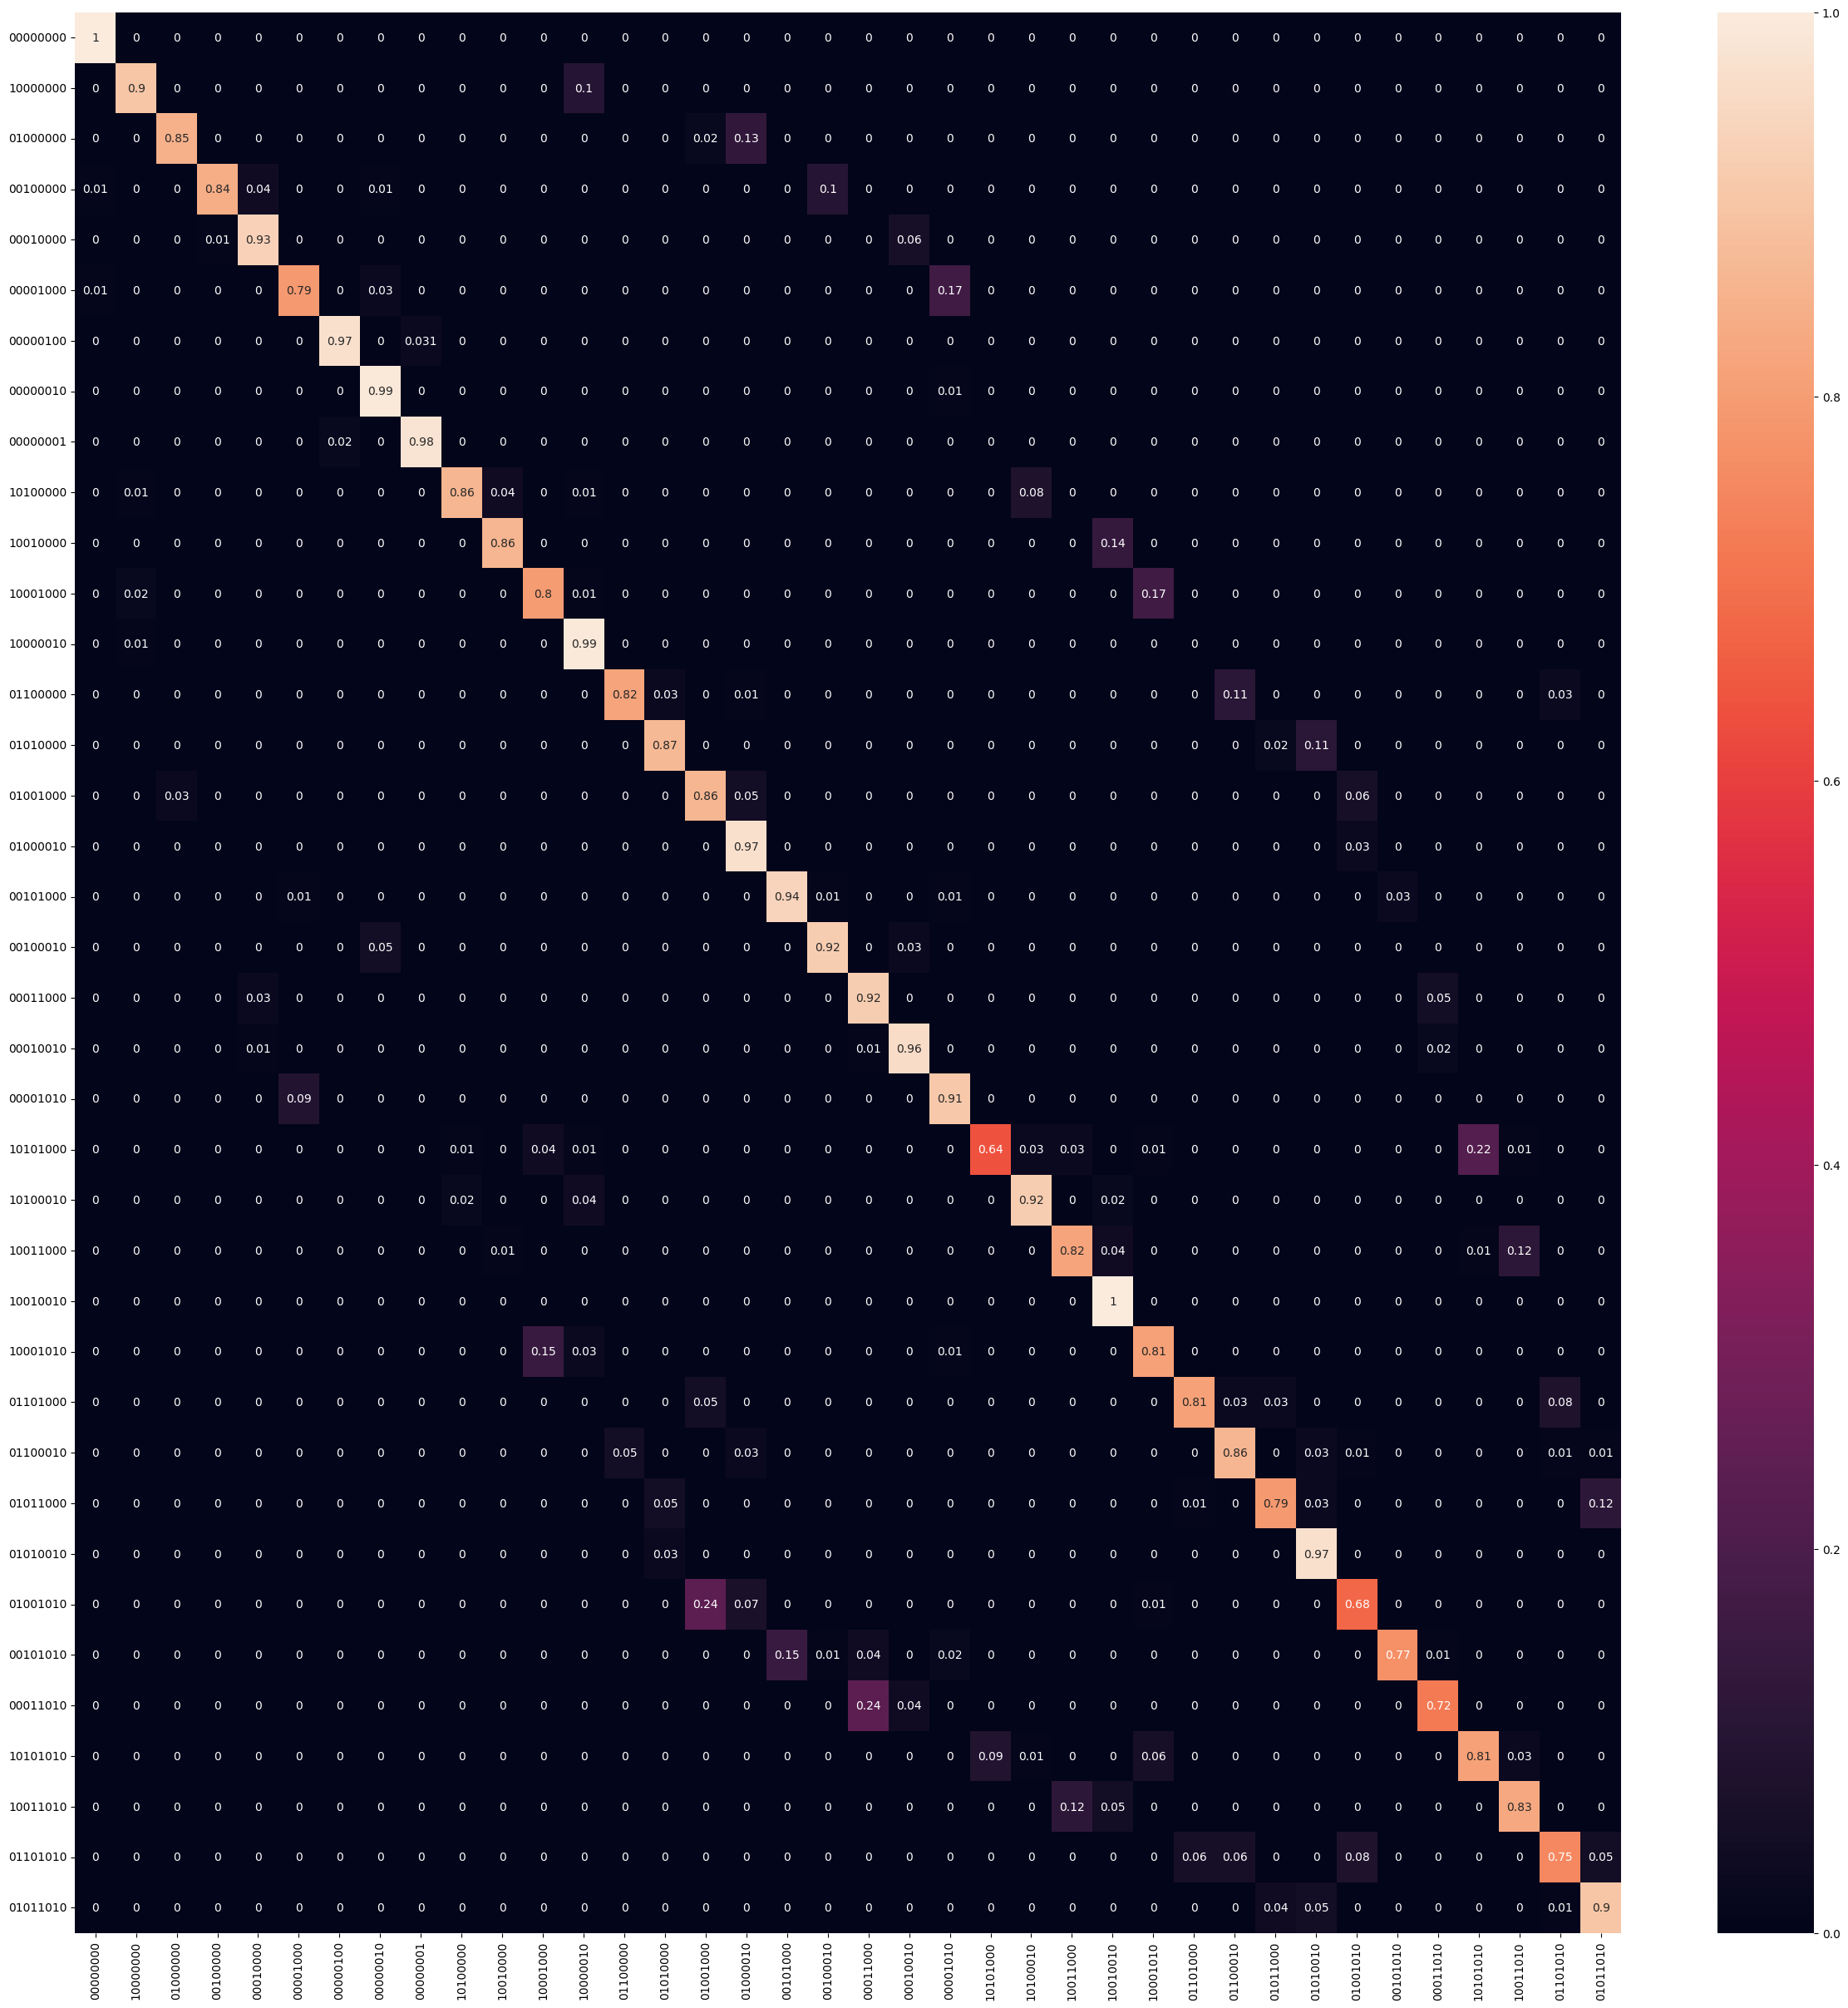

In [ ]:
cf_matrix, y_preds, y_trues = get_confusion_matrix(net, test_loader)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in train_dataset.classes_dict], columns = [i for i in train_dataset.classes_dict])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)

In [ ]:
_, macro_f1 = multiclass_f1(y_trues, y_preds)
print(macro_f1)

0.8677988209753069


### [상황설명]
`10101000` class 등 샘플 수가 적은 class에 대한 성능이 향상되었음을 확인해볼 수 있다.

## [상황 설명 6]

지금까지 38-way multiclass classification 문제를 풀었다면, 해당 문제를 multi-label binary classification 으로 바꿔 해결할 수도 있다.

이러한 방식은 모델 학습 과정에서 shared knowledge를 활용할 수 있도록 한다.

예를 들어, 기존 방식은 `00011000`과 `00011010`을 전혀 다른 label로 취급하지만, <br>
multi-label classification 방식은 둘 사이의 공통된 정보를 파악하여 모델 성능을 개선할 수 있다.


In [ ]:
class Multilabel_Dataset(Dataset):

    def __init__(self, X, y, transform = None):
        self.images = X.reshape(-1,1, 52, 52)
        self.image_labels = y
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.image_labels[idx]
        if self.transform is not None:
            image = Image.fromarray(image[0])
            image = self.transform(image)
        return image, label

In [ ]:
train_dataset = Multilabel_Dataset(X_train, y_train)
test_dataset = Multilabel_Dataset(X_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=4, shuffle=False, num_workers=2, drop_last=False)

이전 문제를 못 풀었거나, 잘못 풀었을 경우를 대비하여 초기화된 모델을 캐시에서 불러온다.

In [ ]:
with open(os.path.join(_dir, 'q6.pkl'), 'rb') as fd:
    net = pickle.load(fd)

Net(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(10, 10))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=20736, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, i

Classifier의 마지막 layer를 주목하자.

In [ ]:
print(net)

Net(
  (features): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(10, 10))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=20736, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, i

### [문제 6-1] Multi-label classification 학습 코드를 완성하시오.

- accuracy 계산을 위한 `preds` 텐서를 계산하시오.
- `preds`는 `nn.Sigmoid`를 활용해 계산한다.
  - sigmoid 출력값이 0.5 이상이면 1, 아니면 0 이다.



### [문제 6-2] 모델 평가 코드를 완성하시오.

- validation accuracy 계산을 위한 `preds`를 계산하시오.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = Adam(net.parameters(), lr=3e-5)
epochs = 5

best_acc = 0.0
for epoch in range(epochs):
    # train
    net.train()
    acc_num = torch.zeros(1).to(device)
    sample_num = 0
    train_bar = tqdm(train_loader, file=sys.stdout, ncols=100)
    for step, data in enumerate(train_bar):
        images, labels = data
        images, labels = images.to(device).float(), labels.to(device).float()
        sample_num += images.shape[0] # 【batch, chennel, height, width】

        # 6-1
        ### Answer Start ###
        optimizer.zero_grad()
        outputs = net(images)

        preds = nn.Sigmoid()(outputs).round()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        ### Answer End ###

        acc_num += torch.all(torch.eq(preds, labels), dim=1).sum()


        train_acc = acc_num.item() / sample_num
        train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch+1, epochs, loss)

    # validate
    net.eval()
    acc_num = 0.0
    with torch.no_grad():
        for val_data in test_loader:
            val_images, val_labels = val_data
            val_images, val_labels = val_images.to(device).float(), val_labels.to(device).float()

            # 6-2
            ### Answer Start ###
            outputs = net(val_images)
            preds = nn.Sigmoid()(outputs).round()
            ### Answer End ###

            acc_num += torch.all(torch.eq(preds, val_labels), dim=1).sum()

    val_accurate = acc_num / val_num
    print('[epoch %d] train_loss: %.3f train_acc: %.3f val_accuracy: %.3f' % (epoch+1, loss, train_acc, val_accurate))

    if val_accurate > best_acc:
        best_acc = val_accurate
    print(f'best accuracy: {best_acc}')


    train_acc = 0.0
    val_accurate = 0.0


print("Finished Training")


train epoch[1/5] loss:0.293: 100%|████████████████████████████████| 335/335 [00:54<00:00,  6.15it/s]
[epoch 1] train_loss: 0.293 train_acc: 0.067 val_accuracy: 0.231
best accuracy: 0.23134131729602814
train epoch[2/5] loss:0.153: 100%|████████████████████████████████| 335/335 [00:54<00:00,  6.20it/s]
[epoch 2] train_loss: 0.153 train_acc: 0.423 val_accuracy: 0.567
best accuracy: 0.5670651197433472
train epoch[3/5] loss:0.098: 100%|████████████████████████████████| 335/335 [00:53<00:00,  6.21it/s]
[epoch 3] train_loss: 0.098 train_acc: 0.684 val_accuracy: 0.811
best accuracy: 0.8106241822242737
train epoch[4/5] loss:0.071: 100%|████████████████████████████████| 335/335 [00:54<00:00,  6.18it/s]
[epoch 4] train_loss: 0.071 train_acc: 0.791 val_accuracy: 0.832
best accuracy: 0.8324037790298462
train epoch[5/5] loss:0.072: 100%|████████████████████████████████| 335/335 [00:54<00:00,  6.19it/s]
[epoch 5] train_loss: 0.072 train_acc: 0.848 val_accuracy: 0.857
best accuracy: 0.856573760509491
